In [1]:
import os
os.chdir("/gpfs/home/asun/jin_lab/GEARS/0_boli/")
print(os.getcwd())
import sys
sys.path.append(os.path.abspath('..'))

from gears import PertData, GEARS

/gpfs/group/jin/asun/GEARS/0_boli


/gpfs/home/asun/miniforge3/envs/gears/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/gpfs/home/asun/miniforge3/envs/gears/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/gpfs/home/asun/miniforge3/envs/gears/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/gpfs/home/asun/miniforge3/envs/gears/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/gpfs/home/asun/miniforge3/envs/gears/lib/python3.12/site-packages/anndata/utils.py:434: Futur

In [2]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
Device count: 4
Device 0: NVIDIA RTX A5000
Device 1: NVIDIA RTX A5000
Device 2: NVIDIA RTX A5000
Device 3: NVIDIA RTX A5000


In [3]:
import gears
print(gears.__file__)

/gpfs/home/asun/miniforge3/envs/gears/lib/python3.12/site-packages/gears/__init__.py


Load data. We use norman as an example.

In [3]:
pert_data = PertData('./data') # specific saved folder
pert_data.load(data_path = './data/boli_l6_ct_norm_specific') # load the processed data, the path is saved folder + dataset_name
pert_data.prepare_split(split = 'simulation_single', seed = 1, test_perts="TBR1+ctrl_SATB2+ctrl",only_test_set_perts=True) # get data split with seed
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128) # prepare data loader

Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['TRIO+ctrl' 'DAB1+ctrl' 'CX3CL1+ctrl']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


here1


Create a model object; if you use [wandb](https://wandb.ai), you can easily track model training and evaluation by setting `weight_bias_track` to true, and specify the `proj_name` and `exp_name` that you like.

In [4]:
gears_model = GEARS(pert_data, device = 'cuda:2', 
                        weight_bias_track = True, 
                        proj_name = 'gears', 
                        exp_name = 'boli_l6_ct_norm_specific')
gears_model.model_initialize(hidden_size = 64)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Found local copy...


You can find available tunable parameters in model_initialize via

In [7]:
gears_model.tunable_parameters()

{'hidden_size': 'hidden dimension, default 64',
 'num_go_gnn_layers': 'number of GNN layers for GO graph, default 1',
 'num_gene_gnn_layers': 'number of GNN layers for co-expression gene graph, default 1',
 'decoder_hidden_size': 'hidden dimension for gene-specific decoder, default 16',
 'num_similar_genes_go_graph': 'number of maximum similar K genes in the GO graph, default 20',
 'num_similar_genes_co_express_graph': 'number of maximum similar K genes in the co expression graph, default 20',
 'coexpress_threshold': 'pearson correlation threshold when constructing coexpression graph, default 0.4',
 'uncertainty': 'whether or not to turn on uncertainty mode, default False',
 'uncertainty_reg': 'regularization term to balance uncertainty loss and prediction loss, default 1',
 'direction_lambda': 'regularization term to balance direction loss and prediction loss, default 1'}

Train your model:

Note: For the sake of demo, we set epoch size to 1. To get full model, set `epochs = 20`.

In [5]:
gears_model.train(epochs = 20, lr = 1e-3)

Start Training...


Epoch 1 Step 1 Train Loss: 0.3622
Epoch 1 Step 51 Train Loss: 0.4235
Epoch 1 Step 101 Train Loss: 0.4362
Epoch 1: Train Overall MSE: 0.0023 Validation Overall MSE: 0.0019. 
Train Top 20 DE MSE: 0.0338 Validation Top 20 DE MSE: 0.0103. 
Epoch 2 Step 1 Train Loss: 0.5115
Epoch 2 Step 51 Train Loss: 0.4473
Epoch 2 Step 101 Train Loss: 0.4440
Epoch 2: Train Overall MSE: 0.0015 Validation Overall MSE: 0.0015. 
Train Top 20 DE MSE: 0.0142 Validation Top 20 DE MSE: 0.0079. 
Epoch 3 Step 1 Train Loss: 0.4123
Epoch 3 Step 51 Train Loss: 0.4758
Epoch 3 Step 101 Train Loss: 0.4209
Epoch 3: Train Overall MSE: 0.0011 Validation Overall MSE: 0.0012. 
Train Top 20 DE MSE: 0.0167 Validation Top 20 DE MSE: 0.0097. 
Epoch 4 Step 1 Train Loss: 0.4749
Epoch 4 Step 51 Train Loss: 0.4304
Epoch 4 Step 101 Train Loss: 0.3861
Epoch 4: Train Overall MSE: 0.0010 Validation Overall MSE: 0.0010. 
Train Top 20 DE MSE: 0.0082 Validation Top 20 DE MSE: 0.0089. 
Epoch 5 Step 1 Train Loss: 0.3969
Epoch 5 Step 51 Train 

Save and load pretrained models:

In [6]:
gears_model.save_model('boli_model_l6_ct_norm_specific')
gears_model.load_pretrained('boli_model_l6_ct_norm_specific')

Make prediction for new perturbation:

In [3]:
gears_model = GEARS(pert_data, device = 'cuda:0')
gears_model.load_pretrained('boli_model')

In [7]:
pert_data.set2conditions

{'test': ['TBR1+ctrl', 'SATB2+ctrl'],
 'train': ['BCL11B+ctrl',
  'ctrl',
  'ANK3+ctrl',
  'CUL1+ctrl',
  'RB1CC1+ctrl',
  'HERC1+ctrl'],
 'val': ['XPO7+ctrl']}

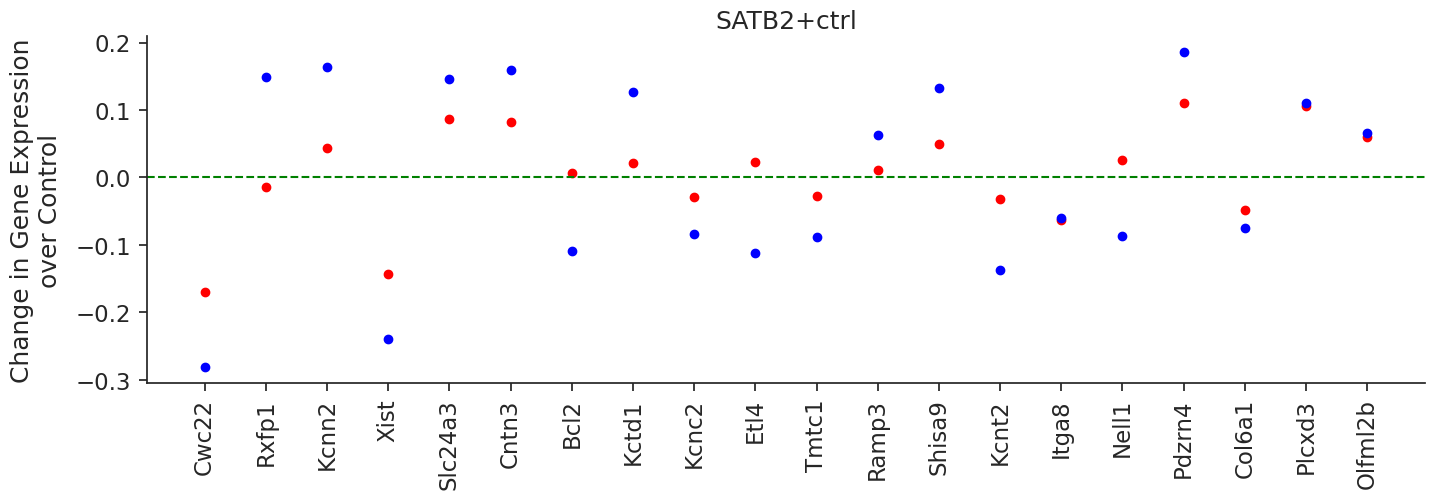

In [10]:
gears_model.plot_perturbation('SATB2+ctrl')

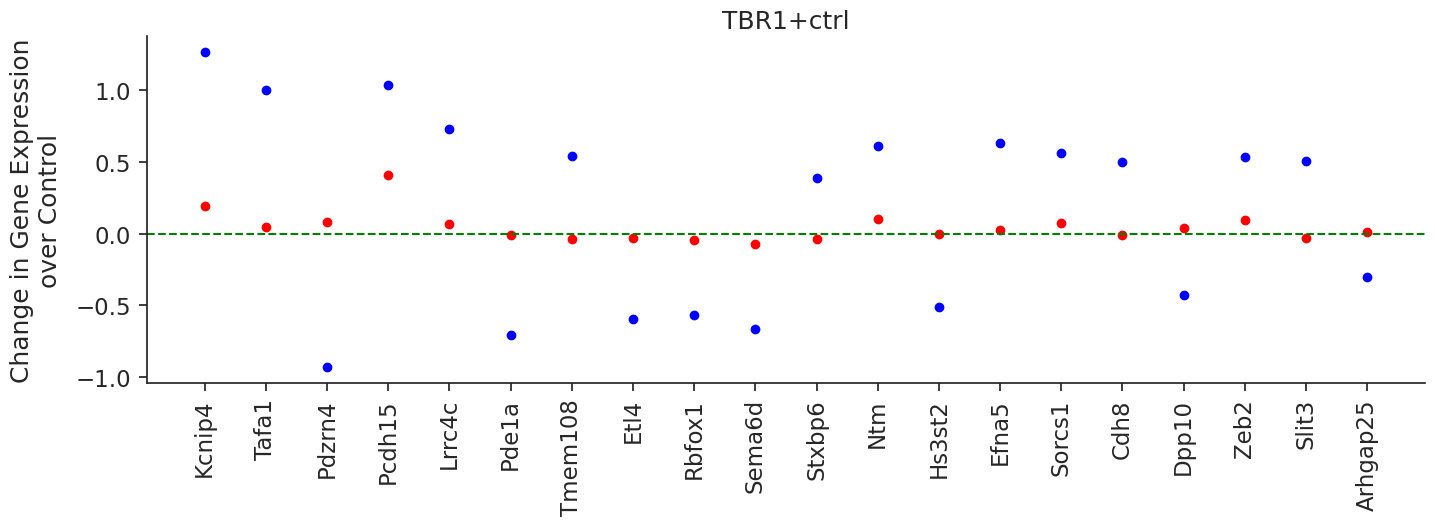

In [9]:
gears_model.plot_perturbation('TBR1+ctrl')

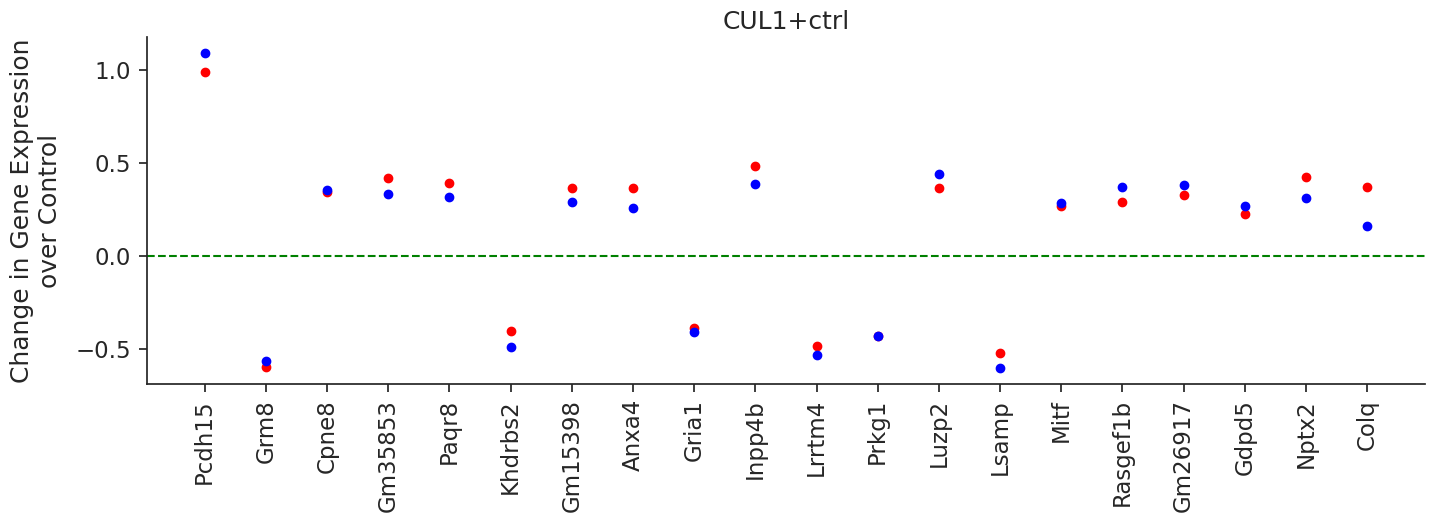

In [11]:
gears_model.plot_perturbation('CUL1+ctrl')

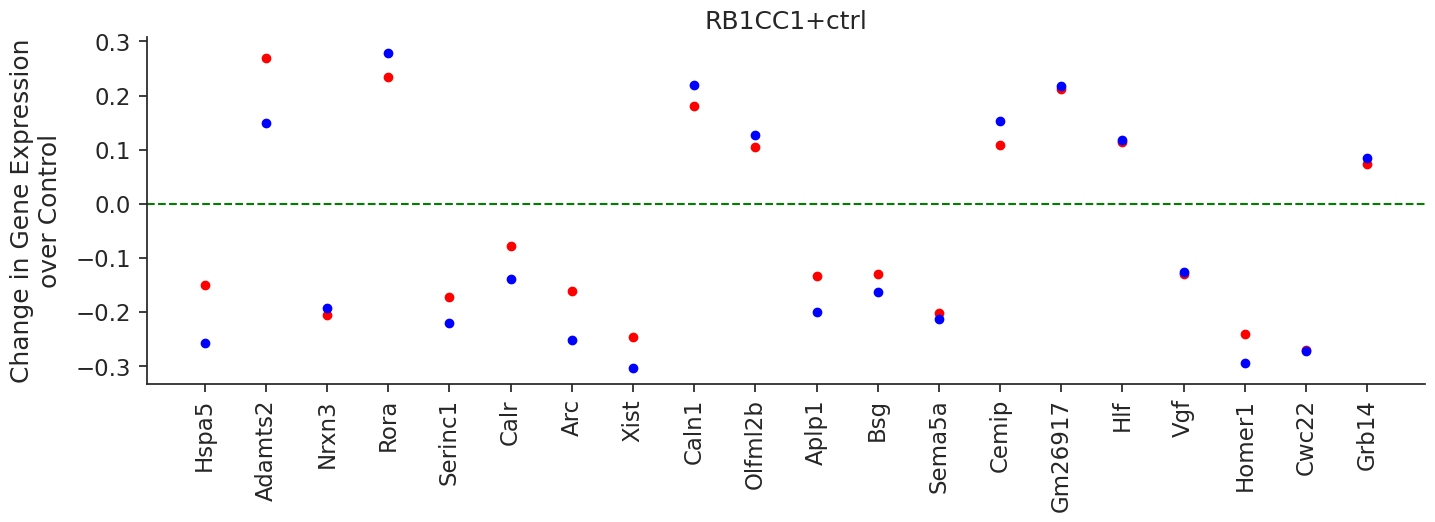

In [13]:
gears_model.plot_perturbation('RB1CC1+ctrl')

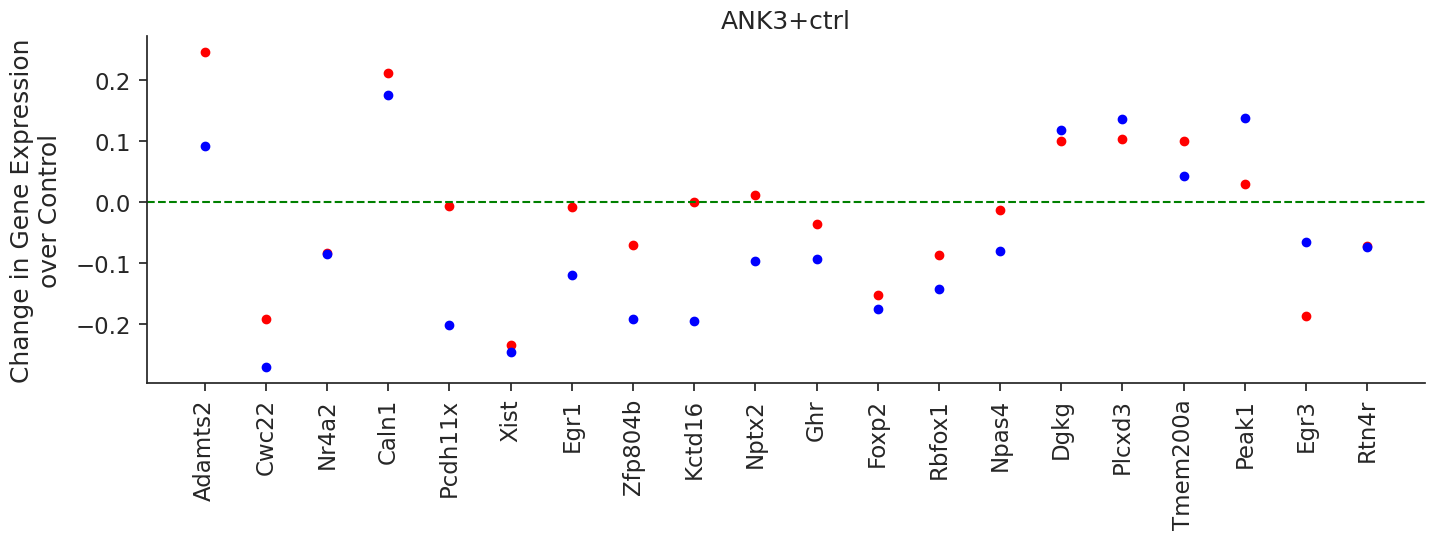

In [12]:
gears_model.plot_perturbation('ANK3+ctrl')

In [11]:
result = gears_model.predict([['TBR1']])

In [12]:
result

{'TBR1': array([-0.00667682,  0.20950113,  0.00617946, ..., -0.01817335,
         0.09775101,  0.42723817], dtype=float32)}

In [13]:
def plot_perturbation_top_fc(self, query, top_n=20, save_file=None):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

    adata = self.adata
    gene2idx = self.node_map
    gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))

    query_ = [q for q in query.split('+') if q != 'ctrl']
    pred_all = self.predict([query_])['_'.join(query_)]
    
    ctrl_means = adata[adata.obs['condition'] == 'ctrl'].to_df().mean().values
    fold_changes = pred_all - ctrl_means  # change over control

    # Get top N genes by absolute fold change
    top_idx = np.argsort(np.abs(fold_changes))[-top_n:]
    genes = [gene_raw2id[adata.var.index[i]] for i in top_idx]
    pred = fold_changes[top_idx]

    # Plot
    plt.figure(figsize=[16.5,4.5])
    plt.title(query)
    plt.scatter(range(len(pred)), pred, color='red')
    plt.axhline(0, linestyle="dashed", color='green')
    plt.xticks(range(len(pred)), genes, rotation=90)
    plt.ylabel("Change in Gene Expression over Control", labelpad=10)
    sns.despine()

    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()

In [14]:
def plot_perturbation_top_fc(self, query, top_n=20, save_file=None):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

    adata = self.adata
    gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))

    # Predicted fold change
    query_ = [q for q in query.split('+') if q != 'ctrl']
    pred_all = self.predict([query_])['_'.join(query_)]
    ctrl_means = adata[adata.obs['condition'] == 'ctrl'].to_df().mean().values
    pred_fc = pred_all - ctrl_means

    # Ground truth fold change (mean across cells)
    truth = adata[adata.obs['condition'] == query].X.toarray()
    mean_truth = truth.mean(axis=0)
    truth_fc = mean_truth - ctrl_means

    # Select top genes by absolute predicted fold change
    top_idx = np.argsort(np.abs(pred_fc))[-top_n:]
    genes = [gene_raw2id[adata.var.index[i]] for i in top_idx]
    pred_fc_top = pred_fc[top_idx]
    truth_fc_top = truth_fc[top_idx]

    # Plot predicted vs ground truth as dots
    plt.figure(figsize=[16.5,4.5])
    plt.title("Top 20 LogFC Genes in Predicted " + query)
    for i in range(top_n):
        plt.scatter(i+1, pred_fc_top[i], color='red', label='Predicted' if i==0 else "")
        plt.scatter(i+1, truth_fc_top[i], color='blue', label='Truth' if i==0 else "")

    plt.axhline(0, linestyle="dashed", color='green')
    ax = plt.gca()
    ax.set_xticks(range(1, top_n+1))
    ax.set_xticklabels(genes, rotation=90)
    ax.set_ylabel("Change in Gene Expression\nover Control", labelpad=10)
    sns.despine()

    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()

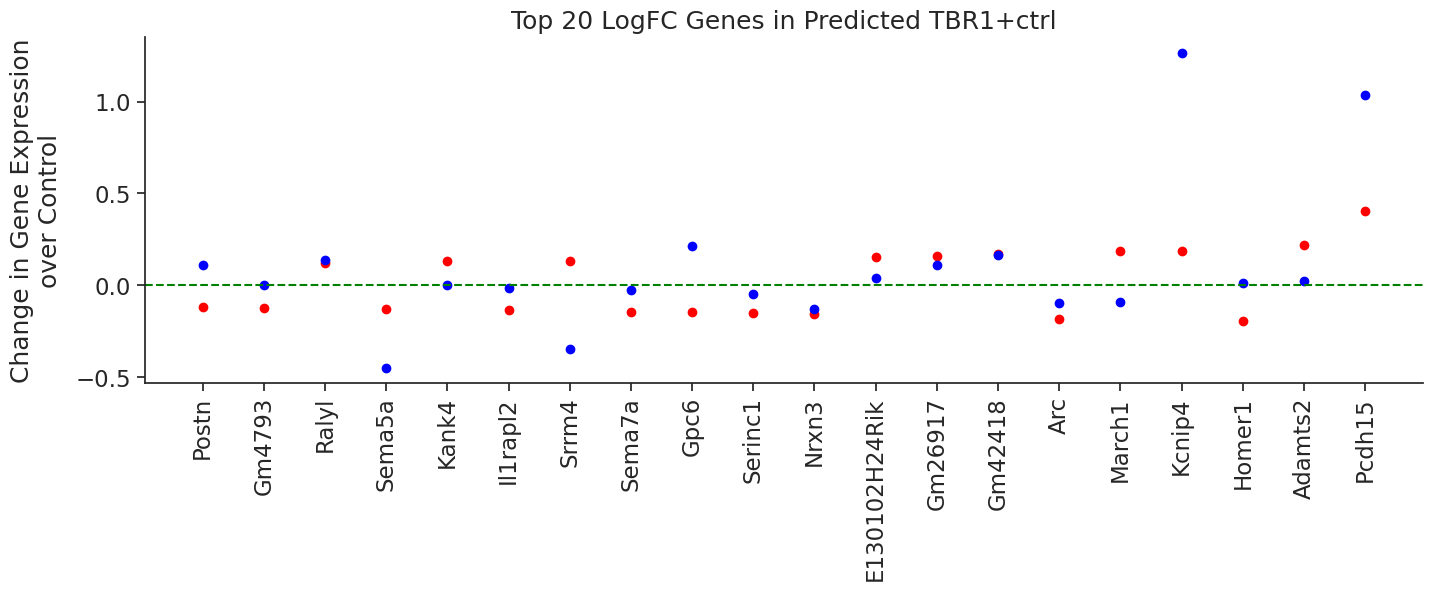

In [15]:
plot_perturbation_top_fc(gears_model, 'TBR1+ctrl')

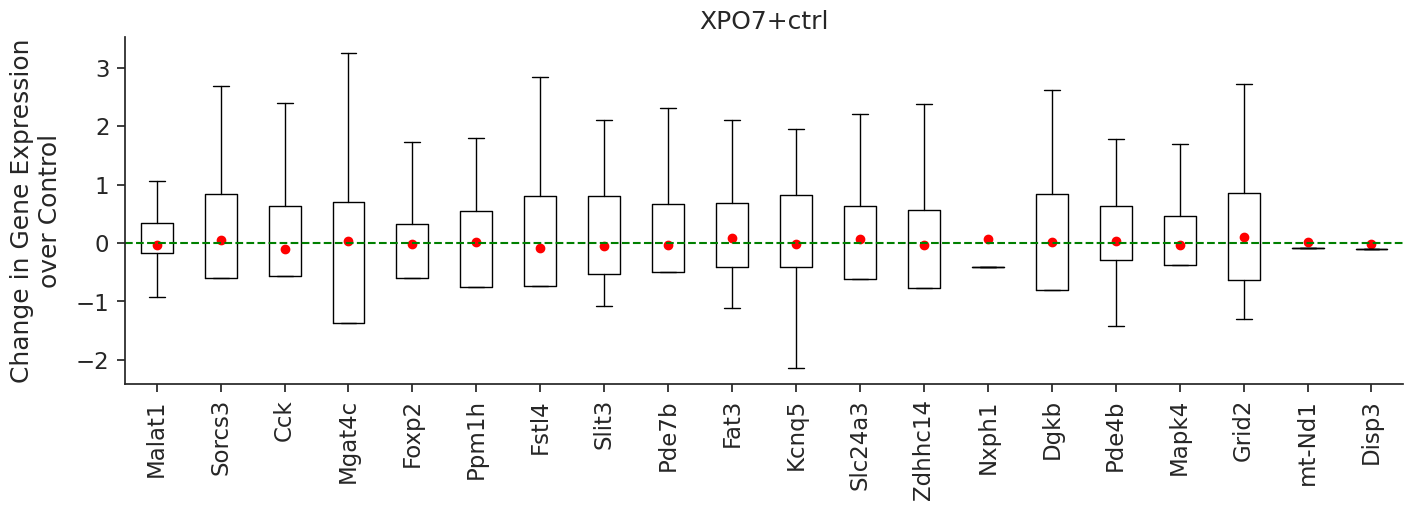

In [5]:
gears_model.plot_perturbation('XPO7+ctrl')

In [14]:
adata = gears_model.adata
cond2name = dict(adata.obs[['condition', 'condition_name']].values)

print(list(adata.uns['top_non_dropout_de_20'].keys()))
print(list(cond2name.keys()))

['Neuron_ANK3+ctrl_1+1', 'Neuron_BCL11B+ctrl_1+1', 'Neuron_CUL1+ctrl_1+1', 'Neuron_CX3CL1+ctrl_1+1', 'Neuron_DAB1+ctrl_1+1', 'Neuron_HERC1+ctrl_1+1', 'Neuron_RB1CC1+ctrl_1+1', 'Neuron_SATB2+ctrl_1+1', 'Neuron_TBR1+ctrl_1+1', 'Neuron_TRIO+ctrl_1+1', 'Neuron_XPO7+ctrl_1+1']
['BCL11B+ctrl', 'XPO7+ctrl', 'ANK3+ctrl', 'TBR1+ctrl', 'ctrl', 'SATB2+ctrl', 'CUL1+ctrl', 'RB1CC1+ctrl', 'HERC1+ctrl']


In [ ]:
print(gears_model.pert_data.perturbations)

In [10]:
result = gears_model.predict([['BCL11B']])

In [13]:
len(result['BCL11B'])

5000

Gene list can be found here:

In [8]:
len(gears_model.gene_list)

5000

# Predict for celleval?

In [20]:
import numpy as np
import pandas as pd
import anndata as ad

In [14]:
perturbations = ['BCL11B', 'XPO7', 'ANK3', 'TBR1', 'SATB2', 'CUL1', 'RB1CC1', 'HERC1']  # or any from your dataset
pred = gears_model.predict([[p] for p in perturbations])

In [17]:
X_pred = np.stack([pred[p] for p in perturbations])  # shape: (n_perturbations, n_genes)

In [21]:
obs_df = pd.DataFrame({
    'condition': perturbations,
    'cell_type': ['Neuron'] * len(perturbations),  # or whatever your cell type is
    'batch': ['GEARS'] * len(perturbations)        # optional but useful
}, index=perturbations)

In [23]:
var_df = gears_model.adata.var.copy()
if 'gene_name' not in var_df.columns:
    var_df['gene_name'] = var_df.index

In [22]:
adata_pred = ad.AnnData(
    X=X_pred,
    obs=obs_df,
    var=var_df
)

,condition,cell_type,batch
BCL11B,BCL11B,Neuron,GEARS
XPO7,XPO7,Neuron,GEARS
ANK3,ANK3,Neuron,GEARS
TBR1,TBR1,Neuron,GEARS
SATB2,SATB2,Neuron,GEARS
CUL1,CUL1,Neuron,GEARS
RB1CC1,RB1CC1,Neuron,GEARS
HERC1,HERC1,Neuron,GEARS


In [30]:
gears_model.adata.obs['condition'].value_counts()


condition
BCL11B+ctrl    5367
ctrl           5224
TBR1+ctrl      3466
RB1CC1+ctrl    2534
SATB2+ctrl     2320
HERC1+ctrl     2165
ANK3+ctrl      1763
XPO7+ctrl      1602
CUL1+ctrl      1297
Name: count, dtype: int64

In [35]:
import numpy as np
import pandas as pd
import anndata as ad

def simulate_deterministic_anndata(gears_model, pert_counts):
    all_X = []
    all_obs = []

    gene_names = gears_model.adata.var['gene_name'].values
    var_df = gears_model.adata.var.copy()

    for cond, n_cells in pert_counts.items():
        if cond == "ctrl":
            # Use control expression vector
            expr = gears_model.ctrl_expression.cpu().numpy()
        else:
            pert = cond.split('+')[0]  # Use only gene name
            pred = gears_model.predict([[pert]])[pert]
            expr = pred  # shape: (n_genes,)

        # Repeat predicted expression n_cells times
        mat = np.tile(expr, (n_cells, 1))
        all_X.append(mat)

        obs_df = pd.DataFrame({
            'condition': [cond] * n_cells,
            'perturbation': [cond.split('+')[0] if cond != "ctrl" else "ctrl"] * n_cells,
        })
        all_obs.append(obs_df)

    # Combine
    X = np.vstack(all_X)
    obs = pd.concat(all_obs, ignore_index=True)

    var_df = gears_model.adata.var.copy()
    if 'gene_name' not in var_df.columns:
        var_df['gene_name'] = var_df.index
    
    adata_sim = ad.AnnData(
        X=X,
        obs=obs,
        var=var_df
    )

    return adata_sim

In [36]:
adata_sim = simulate_deterministic_anndata(gears_model, gears_model.adata.obs['condition'].value_counts())

In [39]:
adata_sim..head(2)

,condition,perturbation
0,BCL11B+ctrl,BCL11B
1,BCL11B+ctrl,BCL11B


In [42]:
gears_model.adata.to_df().head(2)

,4,5,7,11,14,18,19,27,41,42,...,32197,32198,32199,32200,32201,32203,32204,32205,32207,32261
batch1_samp1_chan1_AAACCTGAGACAAAGG-1,0.000000,0.0,0.0,0.0,0.0,0.666819,0.0,0.666819,0.0,0.0,...,0.0,0.666819,0.0,0.0,0.666819,0.0,0.0,0.0,0.0,0.0
batch1_samp1_chan1_AAACCTGAGGCCGAAT-1,0.730666,0.0,0.0,0.0,0.0,0.000000,0.0,1.148331,0.0,0.0,...,0.0,0.730666,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [43]:
adata_sim.write("simulated_adata.h5ad")